In [ ]:
# Chapter 3 - Adversarial examples, solving the inner maximization
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Moving to neural networks

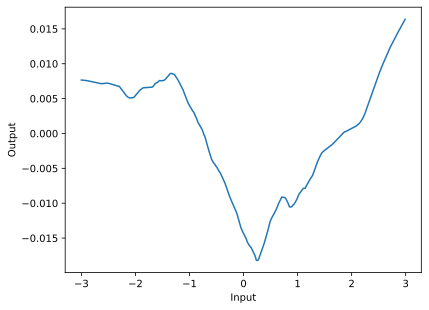

In [ ]:
# Setting a random seed for reproducibility
torch.manual_seed(0)

# The model consists of four linear layers with ReLU activation functions
model = nn.Sequential(
    nn.Linear(1, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 1)
)

# Stochastic Gradient Descent (SGD) with a learning rate of 0.01
opt = optim.SGD(model.parameters(), lr=1e-2)

# Training the model for 100 iterations
for _ in range(100):
    # Generating random input and target tensors
    input_data = torch.randn(100, 1)
    target_data = torch.randn(100, 1)

    # Calculating the mean squared error loss between model predictions and target data
    loss = nn.MSELoss()(model(input_data), target_data)

    # Zeroing out the gradients from previous iterations
    opt.zero_grad()

    # Computing the gradients for the loss
    loss.backward()

    # Updating the model parameters using the optimization algorithm
    opt.step()

# Plotting the model predictions
# Generating input values from -3 to 3 with a step of 0.01
inputs = np.arange(-3, 3, 0.01)
# Getting the model predictions for the input values
outputs = model(torch.tensor(inputs[:, None], dtype=torch.float32)).detach().numpy()

# Plotting the input vs output
plt.plot(inputs, outputs)
plt.xlabel("Input")
plt.ylabel("Output")
plt.show()

### Some example networks

Before we move to discussing the actual attacks, let's train a few simple networks on the MNIST problem.  Again, as we said in the previous Chapter, MNIST is of course an imperfect testbed for such settings because some "simple" strategies like discretization work too well", but it still captures many of the fundamental principles of adversarial robustness.  We're going to actually consider three different architectures here: a two-layer or four-layer fully-connected network, and a network with four convolutional layers plus one fully-connected layer.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Defining a custom module to flatten the input tensor
class Flatten(nn.Module):
    def forward(self, x):
        # Reshaping the input tensor to have shape (batch_size, -1)
        return x.view(x.shape[0], -1)

# Defining a deep neural network model with 2 linear layers
model_dnn_2 = nn.Sequential(
    Flatten(),
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 10)
).to(device)

# Defining a deeper neural network model with 4 linear layers
model_dnn_4 = nn.Sequential(
    Flatten(),
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
).to(device)

# Defining a convolutional neural network model
model_cnn = nn.Sequential(
    nn.Conv2d(1, 32, 3, padding=1),              # First convolutional layer with 1 input channel, 32 output channels, and kernel size of 3x3
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, padding=1, stride=2),
    nn.ReLU(),
    nn.Conv2d(32, 64, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 64, 3, padding=1, stride=2),
    nn.ReLU(),
    Flatten(),
    nn.Linear(7*7*64, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
).to(device)

The following code trains the models

In [ ]:
mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:00<00:00, 16063568.24it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 28881/28881 [00:00<00:00, 634367.75it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:00<00:00, 4526249.12it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<00:00, 3514209.33it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
def epoch(loader, model, opt=None):
    # Initializing total loss and total error
    total_loss, total_err = 0., 0.

    for X, y in loader:
        # Moving the data to the specified device (CPU or GPU)
        X, y = X.to(device), y.to(device)

        # Forward pass: computing model predictions
        yp = model(X)

        # Calculating the loss between the predictions and the true labels
        loss = nn.CrossEntropyLoss()(yp, y)

        # If an optimizer is provided, perform backpropagation and update the model parameters
        if opt:
            opt.zero_grad()   # Zeroing out the gradients from previous iterations
            loss.backward()
            opt.step()        # Updating the model parameters using the optimization algorithm

        # Computing the total error by counting the number of misclassifications
        total_err += (yp.max(dim=1)[1] != y).sum().item()

        total_loss += loss.item() * X.shape[0]

    avg_err = total_err / len(loader.dataset)
    avg_loss = total_loss / len(loader.dataset)

    return avg_err, avg_loss

In [ ]:
# Using Stochastic Gradient Descent (SGD) with a learning rate of 0.1
opt = optim.SGD(model_dnn_2.parameters(), lr=1e-1)

# Training the model for 10 epochs
for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_2, opt)
    test_err, test_loss = epoch(test_loader, model_dnn_2)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.132383	0.517379	0.082800	0.293092
0.075733	0.264427	0.063200	0.223532
0.059017	0.209184	0.053200	0.183886
0.048533	0.172273	0.046500	0.156954
0.041117	0.146377	0.042400	0.141078
0.035433	0.127144	0.037000	0.123754
0.031533	0.112087	0.033800	0.113083
0.027933	0.100114	0.031600	0.104609
0.024700	0.090969	0.030100	0.102986
0.023167	0.082904	0.028100	0.095687


In [ ]:
opt = optim.SGD(model_dnn_4.parameters(), lr=1e-1)

for _ in range(10):
    train_err, train_loss = epoch(train_loader, model_dnn_4, opt)
    test_err, test_loss = epoch(test_loader, model_dnn_4)
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.234567	0.779224	0.079100	0.273246
0.064683	0.218699	0.049100	0.158574
0.042467	0.142816	0.039300	0.126334
0.031850	0.106830	0.031600	0.100235
0.024667	0.084727	0.030500	0.096128
0.020583	0.068081	0.027300	0.084701
0.017617	0.056569	0.025900	0.079224
0.014317	0.047128	0.025100	0.077882
0.011767	0.039319	0.024400	0.073938
0.009783	0.033133	0.021800	0.071125


In [ ]:
opt = optim.SGD(model_cnn.parameters(), lr=1e-1)
for t in range(10):
    train_err, train_loss = epoch(train_loader, model_cnn, opt)
    test_err, test_loss = epoch(test_loader, model_cnn)
    # If the current epoch is 4, reduce the learning rate to 0.01
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2

    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

0.203733	0.603165	0.026100	0.087733
0.024117	0.079749	0.016300	0.052998
0.017383	0.054297	0.013900	0.046737
0.012617	0.039330	0.014500	0.047138
0.009033	0.029374	0.011700	0.035710
0.003767	0.013427	0.009600	0.032408
0.002750	0.010588	0.009700	0.033191
0.002383	0.009359	0.009400	0.033577
0.002100	0.008462	0.009800	0.033802
0.001850	0.007665	0.009600	0.034495


In [ ]:
torch.save(model_dnn_2.state_dict(), "model_dnn_2.pt")
torch.save(model_dnn_4.state_dict(), "model_dnn_4.pt")
torch.save(model_cnn.state_dict(), "model_cnn.pt")

If you don't want to run all the code above, you can simply load the models we trained using the following commands.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/My Drive/CyberAI')

In [ ]:
model_dnn_2.load_state_dict(torch.load("model_dnn_2.pt"))
model_dnn_4.load_state_dict(torch.load("model_dnn_4.pt"))
model_cnn.load_state_dict(torch.load("model_cnn.pt"))

<All keys matched successfully>

Together, these models will serve as a testbed for investigating the ability of different methods for solving the inner maximization problem that we care about.  Some of the approaches we detail below (namely the exact combinatorial methods) are difficult to scale even to the larger MNIST models, though the other approaches can all handle them, and it will be useful to consider the strengths/weaknesses of different approaches.

## Lower bounding the inner maximization (i.e., adversarial attacks)



### The Fast Gradient Sign Method (FGSM)


In [ ]:
def fgsm(model, X, y, epsilon):
 # Initialize the perturbation delta as a tensor of zeros with the same shape as X
    delta = torch.zeros_like(X, requires_grad=True)

    # Compute the loss using the model's predictions on the perturbed input
    loss = nn.CrossEntropyLoss()(model(X + delta), y)

    # Compute the gradients of the loss with respect to the input
    loss.backward()

    # Return the perturbation scaled by epsilon and its sign
    return epsilon * delta.grad.detach().sign()

In [ ]:
# Iterating over the first batch of images and labels from the test data loader
for X, y in test_loader:
    X, y = X.to(device), y.to(device)
    break

# Defining a function to plot images with their predicted and true labels
def plot_images(X, y, yp, M, N):
    # Creating a subplot grid of size M x N
    f, ax = plt.subplots(M, N, sharex=True, sharey=True, figsize=(N, M*1.3))

    # Iterating over the grid
    for i in range(M):
        for j in range(N):
            # Displaying the image
            ax[i][j].imshow(1 - X[i*N + j][0].cpu().numpy(), cmap="gray")

            # Setting the title of the subplot with the predicted label
            title = ax[i][j].set_title("Pred: {}".format(yp[i*N + j].max(dim=0)[1]))

            # Setting the title color based on the correctness of the prediction
            plt.setp(title, color=('g' if yp[i*N + j].max(dim=0)[1] == y[i*N + j] else 'r'))

            # Removing the axis
            ax[i][j].set_axis_off()

    # Adjusting the layout of the subplots
    plt.tight_layout()

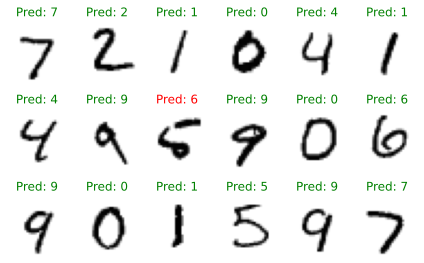

In [ ]:
### Illustrate original predictions
yp = model_dnn_2(X)
plot_images(X, y, yp, 3, 6)

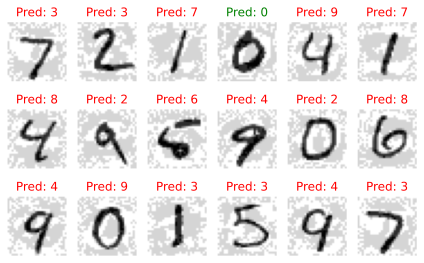

In [ ]:
### Illustrate attacked images
delta = fgsm(model_dnn_2, X, y, 0.1)
yp = model_dnn_2(X + delta)
plot_images(X+delta, y, yp, 3, 6)

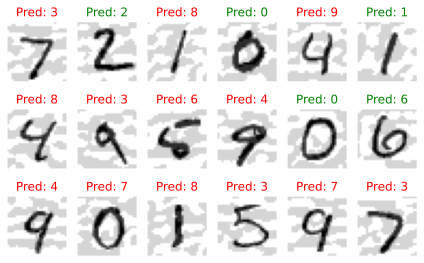

In [ ]:
### Illustrate attacked images
delta = fgsm(model_cnn, X, y, 0.1)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

Seeing the examples visually is nice, but let's evaluate the performance of the attack methods a bit more rigorously.  What do the test errors of our classifiers look like when evaluating against against the FGSM adversarial attack?

In [ ]:
def epoch_adversarial(model, loader, attack, *args):
    # Initialize total loss and total error
    total_loss, total_err = 0., 0.

    # Iterate over each batch in the data loader
    for X, y in loader:
        # Move the batch data to the specified device (CPU or GPU)
        X, y = X.to(device), y.to(device)

        # Generate adversarial perturbation using the specified attack
        delta = attack(model, X, y, *args)

        # Compute model predictions on the adversarial examples
        yp = model(X + delta)

        # Compute the loss between the model predictions and the true labels
        loss = nn.CrossEntropyLoss()(yp, y)

        # Compute the total error by counting the number of misclassifications
        total_err += (yp.max(dim=1)[1] != y).sum().item()

        # Compute the total loss
        total_loss += loss.item() * X.shape[0]

    # Compute the average error and average loss over the entire dataset
    avg_err = total_err / len(loader.dataset)
    avg_loss = total_loss / len(loader.dataset)

    return avg_err, avg_loss

In [ ]:
print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, fgsm, 0.1)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, fgsm, 0.1)[0])
print("        CNN:", epoch_adversarial(model_cnn, test_loader, fgsm, 0.1)[0])

2-layer DNN: 0.9134
4-layer DNN: 0.9338
        CNN: 0.4532


### Projected gradient descent

In [ ]:
def pgd(model, X, y, epsilon, alpha, num_iter):
    # Initialize the perturbation delta as a tensor of zeros with the same shape as X
    delta = torch.zeros_like(X, requires_grad=True)

    # Perform PGD iterations
    for t in range(num_iter):
        # Compute the loss using the model's predictions on the perturbed input
        loss = nn.CrossEntropyLoss()(model(X + delta), y)

        # Compute the gradients of the loss with respect to the input (perturbation)
        loss.backward()

        # Update the perturbation using PGD update rule
        delta.data = (delta + alpha * delta.grad.data.sign()).clamp(-epsilon, epsilon)

        # Reset the gradients for the next iteration
        delta.grad.zero_()

    # Detach the perturbation from the computation graph
    return delta.detach()

Let's first look at a few of the samples that we generate with this method on the CNN model.

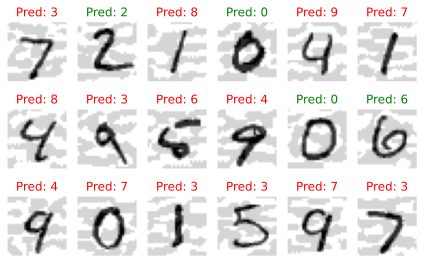

In [ ]:
### Illustrate attacked images
delta = pgd(model_cnn, X, y, 0.1, 1e4, 1000)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [ ]:
# Initialize the perturbation delta as a tensor of zeros with the same shape as X
delta = torch.zeros_like(X, requires_grad=True)

# Compute the loss for the perturbed input and backward propagate the gradients
loss = nn.CrossEntropyLoss()(model_cnn(X + delta), y)
loss.backward()

# Compute and print the average absolute gradient magnitude
print(delta.grad.abs().mean().item())

3.443387413426535e-06


### Steepest Descent.

In [ ]:
def pgd_linf(model, X, y, epsilon, alpha, num_iter):
    # Initialize the perturbation delta as a tensor of zeros with the same shape as X
    delta = torch.zeros_like(X, requires_grad=True)

    # Perform PGD iterations
    for t in range(num_iter):
        # Compute the loss using the model's predictions on the perturbed input
        loss = nn.CrossEntropyLoss()(model(X + delta), y)

        # Compute the gradients of the loss with respect to the input
        loss.backward()

        # Update the perturbation using PGD update rule with L-infinity norm
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)

        # Reset the gradients for the next iteration
        delta.grad.zero_()

    # Detach the perturbation from the computation graph
    return delta.detach()

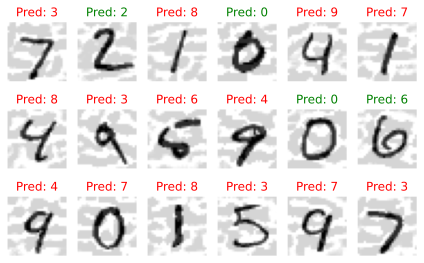

In [ ]:
### Illustrate attacked images
delta = pgd_linf(model_cnn, X, y, epsilon=0.1, alpha=1e-2, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [ ]:
print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])
print("CNN:", epoch_adversarial(model_cnn, test_loader, pgd_linf, 0.1, 1e-2, 40)[0])

2-layer DNN: 0.9547
4-layer DNN: 0.9877
CNN: 0.7375


##Ramdomization


In [ ]:
def pgd_linf_rand(model, X, y, epsilon, alpha, num_iter, restarts):
# Initialize tensors to keep track of maximum loss and corresponding delta
    max_loss = torch.zeros(y.shape[0]).to(y.device)
    max_delta = torch.zeros_like(X)

    # Perform random restarts
    for i in range(restarts):
        # Initialize a random perturbation delta
        delta = torch.rand_like(X, requires_grad=True)

        # Scale and shift the perturbation to be within the [-epsilon, epsilon] range
        delta.data = delta.data * 2 * epsilon - epsilon

        # Perform PGD iterations
        for t in range(num_iter):
            # Compute the loss using the model's predictions on the perturbed input
            loss = nn.CrossEntropyLoss()(model(X + delta), y)

            # Compute the gradients of the loss with respect to the input (perturbation)
            loss.backward()

            # Update the perturbation using PGD update rule with L-infinity norm
            delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)

            # Reset the gradients for the next iteration
            delta.grad.zero_()

        # Compute the loss for all samples
        all_loss = nn.CrossEntropyLoss(reduction='none')(model(X + delta), y)

        # Update max_delta and max_loss based on the current perturbation delta and loss
        max_delta[all_loss >= max_loss] = delta.detach()[all_loss >= max_loss]
        max_loss = torch.max(max_loss, all_loss)

    # Return the perturbation with maximum loss
    return max_delta

In [ ]:
print("CNN:", epoch_adversarial(model_cnn, test_loader, pgd_linf_rand, 0.1, 1e-2, 40, 10)[0])

CNN: 0.7561


### Targeted attacks



In [ ]:
def pgd_linf_targ(model, X, y, epsilon, alpha, num_iter, y_targ):
       # Initialize the perturbation delta as a tensor of zeros with the same shape as X
    delta = torch.zeros_like(X, requires_grad=True)

    # Perform PGD iterations
    for t in range(num_iter):
        # Compute the model's predictions on the perturbed input
        yp = model(X + delta)

        # Compute the targeted loss
        loss = (yp[:, y_targ] - yp.gather(1, y[:, None])[:, 0]).sum()

        # Compute the gradients of the loss with respect to the input (perturbation)
        loss.backward()

        # Update the perturbation using PGD update rule with L-infinity norm
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)

        # Reset the gradients for the next iteration
        delta.grad.zero_()

    # Detach the perturbation from the computation graph
    return delta.detach()

Let's look at trying to make the class label all equation to 2.

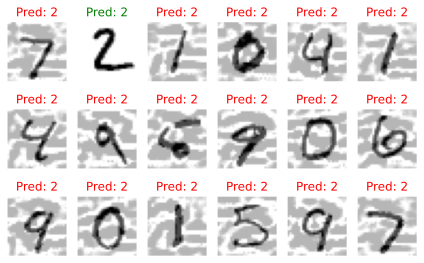

In [ ]:
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=2)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

This looks pretty good: albeit with a slightly larger $\epsilon$, we can fool the classifier into predicting that all the examples are class 2 (note that the actual 2 is unchanged, because the loss function in this case is always exactly zero).  Let's try using a target class of 0 instead.

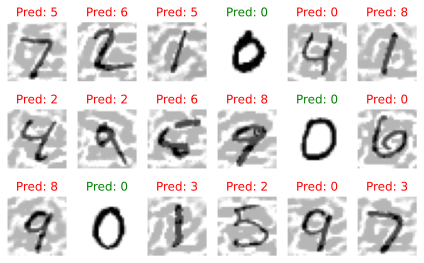

In [ ]:
delta = pgd_linf_targ(model_cnn, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=0)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [ ]:
def pgd_linf_targ2(model, X, y, epsilon, alpha, num_iter, y_targ):
    # Initialize the perturbation delta as a tensor of zeros with the same shape as X
    delta = torch.zeros_like(X, requires_grad=True)

    # Perform PGD iterations
    for t in range(num_iter):
        # Compute the model's predictions on the perturbed input
        yp = model(X + delta)

        # Compute the targeted loss
        loss = 2 * yp[:, y_targ].sum() - yp.sum()

        # Compute the gradients of the loss with respect to the input (perturbation)
        loss.backward()

        # Update the perturbation using PGD update rule with L-infinity norm
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)

        # Reset the gradients for the next iteration
        delta.grad.zero_()

    # Detach the perturbation from the computation graph
    return delta.detach()

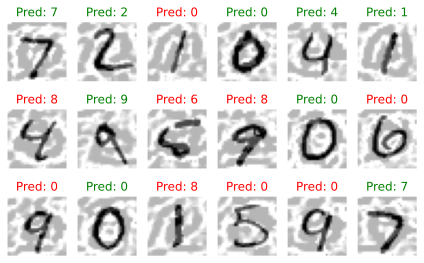

In [ ]:
delta = pgd_linf_targ2(model_cnn, X, y, epsilon=0.2, alpha=1e-2, num_iter=40, y_targ=0)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

This is a more difficult objective than the previous one, so we aren't able to fool the classifier as much.  But when we _do_ fool the classifier, it more consistently (even if still not perfectly) able to predict the target class.

### Non-$\ell_\infty$ norms


In [ ]:
def norms(Z):
    """
    Parameters:
    - Z: Input tensor

    Returns:
    - Norms of the input tensor
    """
    return Z.view(Z.shape[0], -1).norm(dim=1)[:, None, None, None]


def pgd_l2(model, X, y, epsilon, alpha, num_iter):
 # Initialize the perturbation delta as a tensor of zeros with the same shape as X
    delta = torch.zeros_like(X, requires_grad=True)

    # Perform PGD iterations
    for t in range(num_iter):
        # Compute the loss using the model's predictions on the perturbed input
        loss = nn.CrossEntropyLoss()(model(X + delta), y)

        # Compute the gradients of the loss with respect to the input (perturbation)
        loss.backward()

        # Update the perturbation using PGD update rule with L2 norm
        delta.data += alpha * delta.grad.detach() / norms(delta.grad.detach())

        # Clip X+delta to [0,1]
        delta.data = torch.min(torch.max(delta.detach(), -X), 1 - X)

        # Normalize the perturbation to have L2 norm of epsilon
        delta.data *= epsilon / norms(delta.detach()).clamp(min=epsilon)

        # Reset the gradients for the next iteration
        delta.grad.zero_()

    # Detach the perturbation from the computation graph
    return delta.detach()

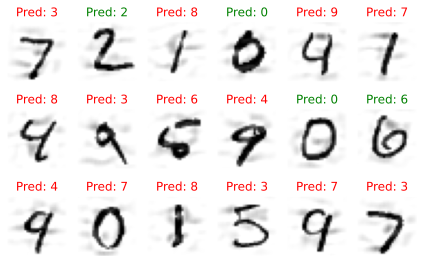

In [ ]:
delta = pgd_l2(model_cnn, X, y, epsilon=2, alpha=0.1, num_iter=40)
yp = model_cnn(X + delta)
plot_images(X+delta, y, yp, 3, 6)

In [ ]:
print("2-layer DNN:", epoch_adversarial(model_dnn_2, test_loader, pgd_l2, 2, 0.1, 40)[0])
print("4-layer DNN:", epoch_adversarial(model_dnn_4, test_loader, pgd_l2, 2, 0.1, 40)[0])
print("CNN:", epoch_adversarial(model_cnn, test_loader, pgd_l2, 2, 0.1, 40)[0])

2-layer DNN: 0.9119
4-layer DNN: 0.953
CNN: 0.7984


### Exactly Solving the Inner Maximization Using Combinatorial Optimization

### Finding upper and lower bounds


In [ ]:
def bound_propagation(model, initial_bound):
    # Initialize lower and upper bounds
    l, u = initial_bound
    bounds = []

    # Iterate through each layer in the model
    for layer in model:
        # Flatten layer
        if isinstance(layer, Flatten):
            l_ = Flatten()(l)
            u_ = Flatten()(u)

        # Linear (fully connected) layer
        elif isinstance(layer, nn.Linear):
            l_ = (layer.weight.clamp(min=0) @ l.t() +
                  layer.weight.clamp(max=0) @ u.t() +
                  layer.bias[:, None]).t()

            u_ = (layer.weight.clamp(min=0) @ u.t() +
                  layer.weight.clamp(max=0) @ l.t() +
                  layer.bias[:, None]).t()

        # Convolutional layer
        elif isinstance(layer, nn.Conv2d):
            l_ = (nn.functional.conv2d(l, layer.weight.clamp(min=0), bias=None,
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(u, layer.weight.clamp(max=0), bias=None,
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  layer.bias[None, :, None, None])

            u_ = (nn.functional.conv2d(u, layer.weight.clamp(min=0), bias=None,
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(l, layer.weight.clamp(max=0), bias=None,
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  layer.bias[None, :, None, None])

        # ReLU activation layer
        elif isinstance(layer, nn.ReLU):
            l_ = l.clamp(min=0)
            u_ = u.clamp(min=0)

        # Append the computed bounds for the current layer to the bounds list
        bounds.append((l_, u_))

        # Update the lower and upper bounds for the next layer
        l, u = l_, u_

    # Return the bounds for each layer
    return bounds

In [ ]:
epsilon = 0.1
bounds = bound_propagation(model_cnn, ((X - epsilon).clamp(min=0), (X + epsilon).clamp(max=1)))
print("lower bound: ", bounds[-1][0][0].detach().cpu().numpy())
print("upper bound: ", bounds[-1][1][0].detach().cpu().numpy())

lower bound:  [-2832.1333 -2632.1301 -3593.327  -2685.7456 -2938.317  -2500.511
 -2951.7102 -2402.5813 -2509.2617 -2574.5725]
upper bound:  [2391.741  2682.3281 2498.2922 2713.2664 2813.4792 3083.041  2226.796
 3209.0332 3071.8394 2805.5173]


So these bounds tell us that for a perturbation delta of $\epsilon=0.1$, the logit corresponding to the zero class for the first MNIST test example is ... somewhere in the range $[-2998, 2305]$.  That's not particularly useful, for determining what the prediction will be but it's better than the $[-10^{100}, 10^100]$, so will help a lot for the integer program.  As you can see from the above formula, too, these bounds get much weaker for deep networks, as the errors in the bounds have time to build up in each successive layer.  For instance, here are the bounds we get for the two layer and four layer networks.

In [ ]:
epsilon = 0.1
bounds = bound_propagation(model_dnn_2, ((X - epsilon).clamp(min=0), (X + epsilon).clamp(max=1)))
print("lower bound: ", bounds[-1][0][0].detach().cpu().numpy())
print("upper bound: ", bounds[-1][1][0].detach().cpu().numpy())

lower bound:  [-20.5941   -23.661787 -17.552198 -16.682325 -32.181896 -22.770075
 -30.564999 -15.766448 -23.637918 -25.119108]
upper bound:  [19.27595  14.368004 25.743185 29.526669 18.749735 28.675268 11.872039
 32.16421  23.783772 25.616161]


In [ ]:
epsilon = 0.1
bounds = bound_propagation(model_dnn_4, ((X - epsilon).clamp(min=0), (X + epsilon).clamp(max=1)))
print("lower bound: ", bounds[-1][0][0].detach().cpu().numpy())
print("upper bound: ", bounds[-1][1][0].detach().cpu().numpy())

lower bound:  [-219.44278 -205.6842  -187.00206 -221.04308 -229.61305 -178.45605
 -244.13887 -202.0461  -207.84274 -204.52637]
upper bound:  [191.96173 210.3965  179.098   211.64948 194.87509 214.8247  192.0029
 239.161   209.27278 219.67776]


Better, but still not all that useful on it's own.  We'll come back to this shortly, however, because with the right training procedure, such bounds actually _can_ be useful.  For now, however, let's focus on the use of the bounds within the integer program.

### A final integer programming formulation

In [ ]:
!pip install cvxpy
!pip install gurobipy
import cvxpy as cp
import gurobipy as gp

In [ ]:
def form_milp(model, c, initial_bounds, bounds):

    # Extract linear layers and their bounds
    linear_layers = [(layer, bound) for layer, bound in zip(model, bounds) if isinstance(layer, nn.Linear)]
    d = len(linear_layers) - 1

    # Create cvxpy variables
    z = ([cp.Variable(layer.in_features) for layer, _ in linear_layers] +
         [cp.Variable(linear_layers[-1][0].out_features)])
    v = [cp.Variable(layer.out_features, boolean=True) for layer, _ in linear_layers[:-1]]

    # Extract relevant matrices
    W = [layer.weight.detach().cpu().numpy() for layer, _ in linear_layers]
    b = [layer.bias.detach().cpu().numpy() for layer, _ in linear_layers]
    l = [l[0].detach().cpu().numpy() for _, (l, _) in linear_layers]
    u = [u[0].detach().cpu().numpy() for _, (_, u) in linear_layers]
    l0 = initial_bounds[0][0].view(-1).detach().cpu().numpy()
    u0 = initial_bounds[1][0].view(-1).detach().cpu().numpy()

    # Add ReLU constraints
    constraints = []
    for i in range(len(linear_layers) - 1):
        constraints += [z[i + 1] >= W[i] @ z[i] + b[i],
                        z[i + 1] >= 0,
                        cp.multiply(v[i], u[i]) >= z[i + 1],
                        W[i] @ z[i] + b[i] >= z[i + 1] + cp.multiply((1 - v[i]), l[i])]

    # Final linear constraint
    constraints += [z[d + 1] == W[d] @ z[d] + b[d]]

    # Initial bound constraints
    constraints += [z[0] >= l0, z[0] <= u0]

    # Formulate and return the MILP problem
    return cp.Problem(cp.Minimize(c @ z[d + 1]), constraints), (z, v)

In order to quickly solve this MILP without additional simplifications, we actually need to consider an even smaller network than we have been using so far.  The following code will build and train a three layer network with hidden units of size 50 and 20.  As before, you can just load the model if you don't want to train.

In [ ]:
model_small = nn.Sequential(Flatten(), nn.Linear(784,50), nn.ReLU(),
                            nn.Linear(50,20), nn.ReLU(),
                            nn.Linear(20,10)).to(device)

In [ ]:
# Define the SGD optimizer with a learning rate of 0.1
opt = optim.SGD(model_small.parameters(), lr=1e-1)

# Train the model for 10 epochs
for _ in range(10):
    # Compute training error and loss
    train_err, train_loss = epoch(train_loader, model_small, opt)

    # Compute test error and loss
    test_err, test_loss = epoch(test_loader, model_small)

    # Print the training and test error and loss
    print(*("{:.6f}".format(i) for i in (train_err, train_loss, test_err, test_loss)), sep="\t")

# Save the trained model to disk
torch.save(model_small.state_dict(), "model_small.pt")

0.203150	0.686423	0.088600	0.310644
0.077200	0.264954	0.058200	0.206983
0.056217	0.194308	0.046100	0.165294
0.045450	0.155191	0.040200	0.137560
0.038550	0.130503	0.038100	0.130908
0.033433	0.113868	0.036600	0.121162
0.030217	0.101238	0.033100	0.112093
0.026983	0.090865	0.030400	0.104233
0.024683	0.082259	0.029300	0.099588
0.023067	0.075211	0.028800	0.098641


In [ ]:
# load model from disk
model_small.load_state_dict(torch.load("model_small.pt"))
# Load model from disk and map it to CPU
# model_small.load_state_dict(torch.load("model_small.pt", map_location=torch.device('cpu')))


<All keys matched successfully>

In [ ]:
import os
os.environ['GRB_LICENSE_FILE'] = '/content/drive/My Drive/CyberAI/gurobi.lic'

In [ ]:
# Compute the initial bounds for the input
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))

# Compute bounds for each layer using bound propagation
bounds = bound_propagation(model_small, initial_bound)

# Set up the objective function c for the MILP problem
c = np.zeros(10)
c[y[0].item()] = 1  # Coefficient for the true label
c[2] = -1           # Coefficient for class 2

# Formulate the MILP problem
prob, (z, v) = form_milp(model_small, c, initial_bound, bounds)


In [ ]:
params = {
"WLSACCESSID": 'da08aed8-fe67-4c98-be7d-743755c6367a',
"WLSSECRET": '78faa051-07cd-4d02-bc24-a176bab6e183',
"LICENSEID": 2479115,
}
env = gp.Env(params=params)

# Create the model within the Gurobi environment
model = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2479115
Academic license 2479115 - for non-commercial use only - registered to mu___@nevada.unr.edu


Finally, let's solve the integer program using Gurobi.

In [ ]:
# Solve the CVXPY problem using Gurobi
prob.solve(solver=cp.GUROBI, verbose=True)

                                     CVXPY                                     
                                     v1.3.3                                    
(CVXPY) Apr 24 08:55:05 AM: Your problem has 934 variables, 11 constraints, and 0 parameters.
(CVXPY) Apr 24 08:55:05 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 24 08:55:05 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 24 08:55:05 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 24 08:55:05 AM: Compiling problem (target solver=GUROBI).
(CVXPY) Apr 24 08:55:05 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuf

-3.337026167720623

Because the resulting objective is negative, this means that we are able to find a perturbation that makes the class logit for the target class is larger than the class logit for the original class, i.e., we are able to construct an adversarial example.  In this case, solving the MILP (with 70 binary variables) took less than a second, but this will quickly become entirely intractable for larger models (you can try doing the same procedure with our original models above).  We can also do a quick check to validate the formulation we by plugging the initial value into the model and making sure the last layers are the same as what is given by the MILP.

In [ ]:
print("Last layer values from MILP:", z[3].value)

Last layer values from MILP: [ 0.85566307 -0.89136373  8.29259184  4.62129743 -6.95362974 -2.24945768
 -7.29134157  4.95556567  2.43562664 -3.91780692]


In [ ]:
print("Last layer from model:",
      model_small(torch.tensor(z[0].value).float().view(1,1,28,28).to(device))[0].detach().cpu().numpy())

Last layer from model: [ 0.85566294 -0.89136374  8.292592    4.6212974  -6.9536304  -2.2494576
 -7.2913413   4.9555664   2.4356272  -3.9178073 ]


We can also look at the perturbed image, which here is also constrained to lie within $[0,1]$ by the nature of our original bounds.

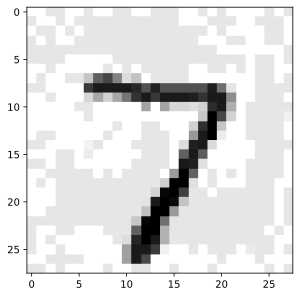

In [ ]:
plt.imshow(1-z[0].value.reshape(28,28), cmap="gray")

**Certifying Robustness**

In [ ]:
# Define the perturbation size
epsilon = 0.05

# Compute the initial bounds for the input
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))

# Compute bounds for each layer using bound propagation
bounds = bound_propagation(model_small, initial_bound)

# Iterate over each target class
for y_targ in range(10):
    # Skip the true class
    if y_targ != y[0].item():
        # Set up the objective function c for the targeted attack
        c = np.eye(10)[y[0].item()] - np.eye(10)[y_targ]

        # Formulate the MILP problem for the targeted attack
        prob, _ = form_milp(model_small, c, initial_bound, bounds)

        # Solve the MILP problem and print the objective value
        print("Targeted attack {} objective: {}".format(y_targ, prob.solve(solver=cp.GUROBI)))

Targeted attack 0 objective: 5.663196906085332
Targeted attack 1 objective: 11.457153355489828
Targeted attack 2 objective: 3.7495470458211173
Targeted attack 3 objective: 2.5422790620846323
Targeted attack 4 objective: 13.323886122692478
Targeted attack 5 objective: 9.683112800990731
Targeted attack 6 objective: 17.663183265235823
Targeted attack 8 objective: 5.997970828535375
Targeted attack 9 objective: 4.009769384930948


In [ ]:
# Define the perturbation size
epsilon = 0.1

# Compute the initial bounds for the input
initial_bound = ((X[0:1] - epsilon).clamp(min=0), (X[0:1] + epsilon).clamp(max=1))

# Compute bounds for each layer using bound propagation
bounds = bound_propagation(model_small, initial_bound)

# Iterate over each target class
for y_targ in range(10):
    # Skip the true class
    if y_targ != y[0].item():
        # Set up the objective function c for the targeted attack
        c = np.eye(10)[y[0].item()] - np.eye(10)[y_targ]

        # Formulate the MILP problem for the targeted attack
        prob, _ = form_milp(model_small, c, initial_bound, bounds)

        # Solve the MILP problem and print the objective value
        print("Targeted attack {} objective: {}".format(y_targ, prob.solve(solver=cp.GUROBI)))

Targeted attack 0 objective: -1.378804245413332
Targeted attack 1 objective: 4.246708754462118
Targeted attack 2 objective: -3.337026167720623
Targeted attack 3 objective: -4.4762331874782655
Targeted attack 4 objective: 4.930321956258663
Targeted attack 5 objective: 0.3046839345158334
Targeted attack 6 objective: 6.128987820340877
Targeted attack 8 objective: -3.7845988686686125
Targeted attack 9 objective: -3.5467743466266626
